In [14]:
import pandas as pd
import numpy as np

In [2]:
df=pd.read_csv("../Ntu_DataSet/Orders.csv")

c:\users\alex\appdata\local\programs\python\python36\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
shopping_data=df.copy()

In [4]:
shopping_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5495276 entries, 0 to 5495275
Data columns (total 28 columns):
DateId                         int64
MemberId                       int64
OrderGroupCode                 object
TrackSourceTypeDef             object
TrackDeviceTypeDef             object
PayProfileTypeDef              object
SalesOrderSlaveId              int64
SalePageId                     int64
IsMajor                        bool
IsGift                         bool
IsSalePageGift                 bool
Quantity                       int64
UnitPrice                      float64
PromotionDiscount              float64
ECouponId                      int64
ECouponDiscount                float64
SalesOrderSlaveTotalPayment    float64
SalesOrderSlaveDateTime        object
SalesOrderReceiverId           int64
City                           object
District                       object
ZipCode                        float64
StoreName                      object
StoreId              

In [5]:
shopping_data=shopping_data.ix[:,["DateId","MemberId","OrderGroupCode","IsGift","IsSalePageGift","Quantity","UnitPrice","PromotionDiscount","EcouponId","ECouponDiscount","SalesOrderSlaveTotalPayment"]]

c:\users\alex\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


In [6]:
shopping_data=shopping_data.fillna(0)

In [7]:
shopping_data['DateId']=pd.to_datetime(shopping_data['DateId'],format="%Y%m%d") 

## (1) 顧客分群

以3個月為單位，故分成  2015/07~2015/09，2015/10~2016/12，2016/01~2016/03，2016/04~2016/06，2016/07~2016/09，2016/10~2017/12，2017/01~2017/03  七個時段

In [8]:
shoppingDataList=[]
timeExpend=["2015-07~2015-09","2015-10~2016-12","2016-01~2016-03","2016-04~2016-06","2016-07~2016-09","2016-10~2017-12","2017-01~2017-03"]
for time in timeExpend:
    time=time.split("~")
    temp=shopping_data[shopping_data["DateId"]>=time[0]]
    temp=temp[temp["DateId"]<=time[1]]
    shoppingDataList.append(temp)

In [9]:
newCustomer=[]
activeCustomer=[]
sleepCustomer=[]
customerTotal=[]
customers=[]
for index,customer in enumerate(shoppingDataList):
    if index==0:
        newCustomer.append(set(customer["MemberId"]))
        customerTotal.append(set(customer["MemberId"]))
        activeCustomer.append({})
        sleepCustomer.append({})
        customers.append(set(customer["MemberId"]))
    else:
        tempData=customer.ix[:,["MemberId","OrderGroupCode"]]
#         customerTotal------->所有的消費者
        customerTotalItem=customerTotal[index-1] | set(tempData["MemberId"])
        customerTotal.append(customerTotalItem)
        
#         newCustomer--------->新增加的消費者且期間銷售次數為一次
        tempGroup=tempData.groupby("MemberId")["OrderGroupCode"].nunique()
        newCustomerItem=set(tempGroup.index[tempGroup.values==1]) - customerTotal[index-1] 
        newCustomer.append(newCustomerItem)
        
#         activeCustomer------>主要消費者
        activeCustomerItem=set(tempData["MemberId"])-newCustomerItem
        activeCustomer.append(activeCustomerItem)
        
#         sleepCustomer------->上一期有消費但這期沒消費
        sleepCustomerItem=customerTotal[index-1] - set(tempData["MemberId"])
    
        sleepCustomer.append(sleepCustomerItem)
#         customers----------->這期的消費者
        customers.append(set(tempData["MemberId"]))

c:\users\alex\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


In [10]:
for i in range(len(newCustomer)):
    print("NewCustomer:",len(set(newCustomer[i])))
    print("ActiveCustomer:",len(set(activeCustomer[i])))
    print("SleepCustomer:",len(set(sleepCustomer[i])))
    print("TotalCustomer:",len(set(customerTotal[i])))
    print("Customer:",len(set(customers[i])))
    print("--------------------------------")

NewCustomer: 23748
ActiveCustomer: 0
SleepCustomer: 0
TotalCustomer: 23748
Customer: 23748
--------------------------------
NewCustomer: 193584
ActiveCustomer: 128360
SleepCustomer: 13648
TotalCustomer: 335592
Customer: 321944
--------------------------------
NewCustomer: 0
ActiveCustomer: 34123
SleepCustomer: 301469
TotalCustomer: 335592
Customer: 34123
--------------------------------
NewCustomer: 0
ActiveCustomer: 77670
SleepCustomer: 257922
TotalCustomer: 335592
Customer: 77670
--------------------------------
NewCustomer: 0
ActiveCustomer: 88361
SleepCustomer: 247231
TotalCustomer: 335592
Customer: 88361
--------------------------------
NewCustomer: 115177
ActiveCustomer: 195603
SleepCustomer: 192608
TotalCustomer: 503388
Customer: 310780
--------------------------------
NewCustomer: 0
ActiveCustomer: 35679
SleepCustomer: 467709
TotalCustomer: 503388
Customer: 35679
--------------------------------


In [11]:
newCustomerNumber=[]
activeCustomerNumber=[]
sleepCustomerNumber=[]
for i in range(len(newCustomer)):
    newCustomerNumber.append(len(set(newCustomer[i])))
    activeCustomerNumber.append(len(set(activeCustomer[i])))
    sleepCustomerNumber.append(len(set(sleepCustomer[i])))

In [15]:
interest=[]
for customer in shoppingDataList:
    quantity=np.array(customer["Quantity"])
    salesOrderSlaveTotalPayment=np.array(customer["SalesOrderSlaveTotalPayment"])
    interest.append(np.dot(quantity,salesOrderSlaveTotalPayment))

In [16]:
len(interest)

7

In [17]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
def barsplot():
    fig=plt.figure(figsize=(15,20))
    ax1 = fig.add_subplot(111)
    ax2 = ax1.twinx()
    
    x=[x for x in range(1,8)]
    y1=np.array(newCustomerNumber)
    y2=np.array(activeCustomerNumber)
    y3=np.array(sleepCustomerNumber)
    l1=ax1.bar(x, y1, color='green', label='y1')
    l2=ax1.bar(x, y2, bottom=y1, color='red', label='y2')
    l3=ax1.bar(x, y3, bottom=y1+y2, color='blue', label='y3')
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title("Custumer Classify")
    plt.legend(handles = [l1,l2,l3], labels = ["newCustomerNumber","activeCustomerNumber","sleepCustomerNumber"],loc="best")
    
    for x,x,x,y1,y2,y3 in zip(x,x,x,y1,y2,y3):
        ax1.text(x ,y1, "%.0f" % y1, ha="center",va="center")
        ax1.text(x ,y2+y1, "%.0f" % y2, ha="center",va="center")
        ax1.text(x ,y2+y1+y3, "%.0f" % y3, ha="center",va="center")
    ax2.set_xlim([0,8])
    ax2.plot([x for x in range(1,8)], interest, '-o',color='black')
    plt.show()

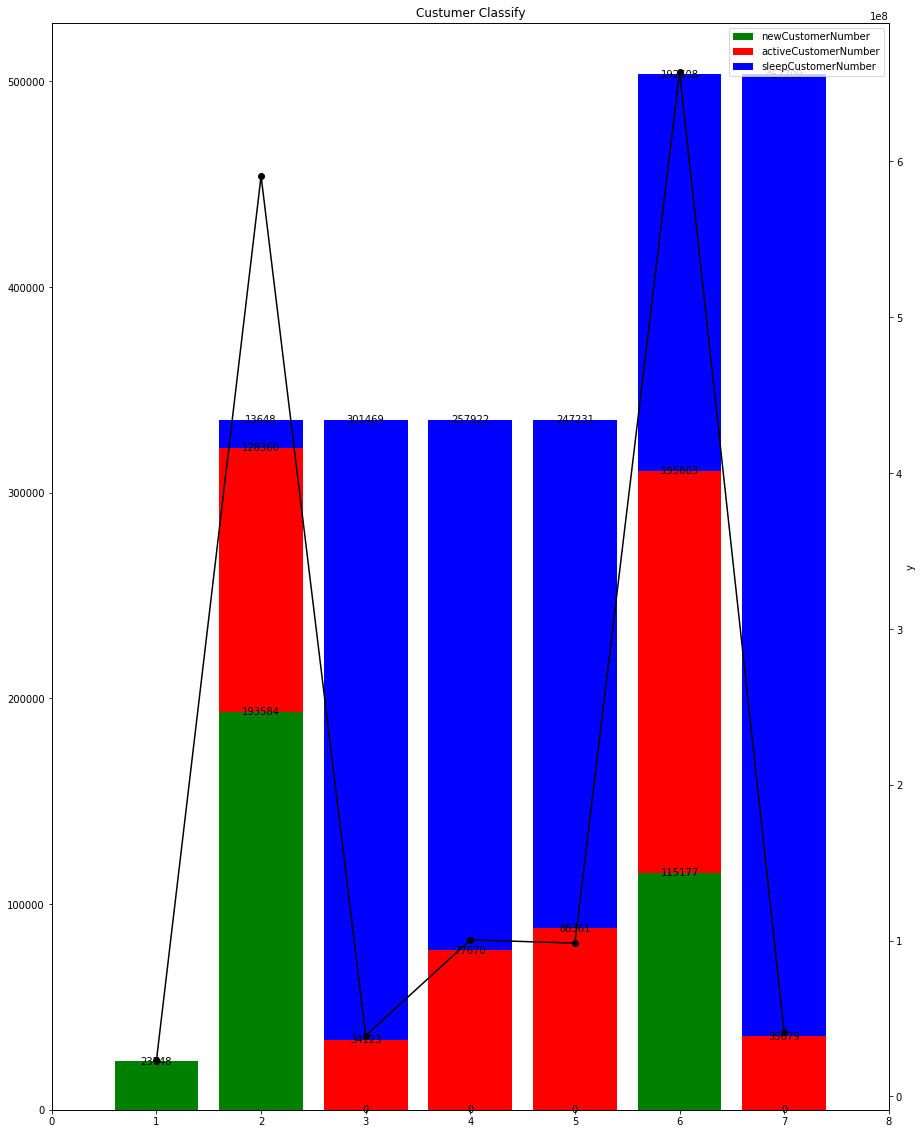

In [18]:
draw=barsplot()

## (2) 促銷對人口流動的影響

In [19]:
df2=pd.read_csv("../Ntu_DataSet/PromotionOrders.csv")

In [20]:
promotion_data=df2.copy()
promotion_data["PromotionId"]=promotion_data["PromotionId"].astype("str")

In [22]:
promotion_data["PromotionId"].describe()

count     4011064
unique        244
top         34032
freq       189210
Name: PromotionId, dtype: object

In [23]:
promotion_data["DiscountType"].describe()

count     4011064
unique          7
top          滿額折現
freq      1727429
Name: DiscountType, dtype: object

In [24]:
del promotion_data["SalesOrderSlaveId"]

In [25]:
promotion_data.info(0)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4011064 entries, 0 to 4011063
Data columns (total 12 columns):
PromotionId                                     object
SalesOrderSlavePromotionDiscount                float64
SalesOrderSlavePromotionDiscountAllocated       float64
SalesOrderSlavePromotionDiscountAllocatedQty    int64
SalesOrderSlavePromotionDiscountRate            float64
DiscountType                                    object
PromotionCondition_DiscountPrice                float64
PromotionCondition_DiscountRate                 float64
PromotionCondition_TotalPrice                   float64
PromotionCondition_TotalQty                     int64
PromotionStartDateTime                          object
PromotionEndDateTime                            object
dtypes: float64(6), int64(2), object(4)
memory usage: 367.2+ MB


In [28]:
PromotionId=promotion_data["PromotionId"].values
# print(1)
DiscountType=promotion_data["DiscountType"].values
# print(1)
PromotionCondition_DiscountPrice=promotion_data["PromotionCondition_DiscountPrice"].values
# print(1)
PromotionCondition_DiscountRate=promotion_data["PromotionCondition_DiscountRate"].values
# print(1)
PromotionCondition_TotalPrice=promotion_data["PromotionCondition_TotalPrice"].values
# print(1)
PromotionCondition_TotalQty=promotion_data["PromotionCondition_TotalQty"].values
# print(1)
PromotionStartDateTime=promotion_data["PromotionStartDateTime"].values
# print(1)
PromotionEndDateTime=promotion_data["PromotionEndDateTime"].values
# print(1)
promotionLs=[]
for promote in np.unique(promotion_data["PromotionId"].values):
    templs=[]
    a=promotion_data["PromotionId"].values
    index=np.argwhere(a==promote)
    index=index[0][0]
    print(index)
    templs.append(PromotionId[index])
    templs.append(DiscountType[index])
    templs.append(PromotionCondition_DiscountPrice[index])
    templs.append(PromotionCondition_DiscountRate[index])
    templs.append(PromotionCondition_TotalPrice[index])
    templs.append(PromotionCondition_TotalQty[index])
    templs.append(PromotionStartDateTime[index])
    templs.append(PromotionEndDateTime[index])
    promotionLs.append(templs)

3366598
3366591
3366587
3366593
3366600
3366635
3365225
3366599
3366595
3596226
3430947
3680333
3680334
3680339
3502343
3680343
3680471
3680268
2152165
2631126
3517777
3430869
3340005
3239274
3339241
3340985
2948422
3254188
2948009
2951756
3165830
3065176
2643583
2856840
2862677
2555039
2161028
3163521
2567601
3173735
2987569
2951525
2998316
2161282
2996593
2771249
2363712
2605670
3186664
2153378
1744251
2821405
1832948
2177994
1822018
2262264
2456928
2354573
2229795
1820430
2440563
2013375
1016250
1338569
1016215
1235407
1016223
1311203
1108833
2085176
1782591
1016241
1920185
2011338
1016214
1769775
926719
1016348
1016211
1016286
1017119
1016812
1016216
954241
1258414
1065412
1552841
939552
1461817
404154
494654
1166940
38800
1167579
404058
314778
494725
494720
21384
404313
161544
250324
249578
250457
110600
148680
135816
7128
46494
788226
792
185846
695304
23519
33928
8712
51416
788357
59504
46680
2576377
2588635
1762065
1762654
2741770
2563641
0
1762215
2981374
2800170
2588644
28005

In [29]:
promotionData=pd.DataFrame(promotionLs,columns=["PromotionId","DiscountType","PromotionCondition_DiscountPrice","PromotionCondition_DiscountRate","PromotionCondition_TotalPrice","PromotionCondition_TotalQty","PromotionStartDateTime","PromotionEndDateTime"])
promotionData=promotionData.sort_values(by="PromotionStartDateTime")
# promotionDate=promotionData["PromotionStartDateTime"].values,promotionData["PromotionStartDateTime"].values
promotionDate=np.vstack((promotionData["PromotionStartDateTime"].values,promotionData["PromotionEndDateTime"].values)).T

In [66]:
from datetime import timedelta, date
promotionTotalDate=[]
promotionTotalDateMatix=[]
def daterange(date1, date2):
    for n in range(int ((date2 - date1).days)+1):
        yield date1 + timedelta(n)
for item in promotionDate:
    temp=[]
    a=item[0].split(" ")[0].split("-")
    b=item[1].split(" ")[0].split("-")
    start_dt = date(int(a[0]), int(a[1]), int(a[2]))
    end_dt = date(int(b[0]), int(b[1]),int(b[2]))
    for dt in daterange(start_dt, end_dt):
        promotionTotalDate.append(dt)
        temp.append(dt)
    promotionTotalDateMatix.append(temp)

In [31]:
promotionTotalDateSet=set(promotionTotalDate)
cc=list(set(shopping_data["DateId"].values))
cc.sort()
a=str(cc[0]).split('T')[0].split("-")
b=str(cc[-1]).split('T')[0].split("-")
shoppingTotalDate=set()
start_dt = date(int(a[0]), int(a[1]), int(a[2]))
end_dt = date(int(b[0]), int(b[1]),int(b[2]))
for dt in daterange(start_dt, end_dt):
        shoppingTotalDate.add(dt)

In [32]:
nn=list(shoppingTotalDate)
nn.sort()

In [69]:
len(promotionTotalDateMatix)

244

In [33]:
nn[0]-nn[-1]

datetime.timedelta(-1075)

In [34]:
df2=pd.read_csv("../Ntu_DataSet/Member.csv")

c:\users\alex\appdata\local\programs\python\python36\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [35]:
Member=list(df2["MinOrderDate"].dropna())
Member.sort()

In [36]:
len(Member)/1075

523.0697674418604

In [37]:
from collections import Counter
aa=np.array(list(Counter(Member).values()))
base=aa.mean()-aa.std()

In [38]:
Counter(Member)

Counter({'2015-05-06': 7,
         '2015-05-07': 10,
         '2015-05-08': 18,
         '2015-05-09': 24,
         '2015-05-10': 25,
         '2015-05-11': 20,
         '2015-05-12': 19,
         '2015-05-13': 19,
         '2015-05-14': 17,
         '2015-05-15': 12,
         '2015-05-16': 27,
         '2015-05-17': 22,
         '2015-05-18': 17,
         '2015-05-19': 16,
         '2015-05-20': 74,
         '2015-05-21': 84,
         '2015-05-22': 70,
         '2015-05-23': 123,
         '2015-05-24': 92,
         '2015-05-25': 84,
         '2015-05-26': 39,
         '2015-05-27': 33,
         '2015-05-28': 58,
         '2015-05-29': 63,
         '2015-05-30': 104,
         '2015-05-31': 99,
         '2015-06-01': 79,
         '2015-06-02': 42,
         '2015-06-03': 74,
         '2015-06-04': 85,
         '2015-06-05': 76,
         '2015-06-06': 101,
         '2015-06-07': 106,
         '2015-06-08': 75,
         '2015-06-09': 67,
         '2015-06-10': 121,
         '2015-06-11': 1

In [41]:
from sympy import *

In [93]:
a=list(range(244))
for i in range(len(a)):
    a[i]=symbols('a'+str(i))

In [100]:
promotionTotalDateList=list(promotionTotalDateSet)
promotionTotalDateList.sort()

In [158]:
matrix=[]
for i in range(len(promotionTotalDateMatix)):
    mask = np.isin(promotionTotalDateList,promotionTotalDateMatix[i])
    mask=mask.astype(int)
    matrix.append(list(mask))

In [130]:
ee=np.array(matrix).T
np.dot(ee[547],a)
equal=[]
for i in range(len(ee)):
    equal.append(np.dot(ee[i],a))

In [137]:
list(Counter(Member).values())

[7,
 10,
 18,
 24,
 25,
 20,
 19,
 19,
 17,
 12,
 27,
 22,
 17,
 16,
 74,
 84,
 70,
 123,
 92,
 84,
 39,
 33,
 58,
 63,
 104,
 99,
 79,
 42,
 74,
 85,
 76,
 101,
 106,
 75,
 67,
 121,
 184,
 280,
 294,
 296,
 281,
 248,
 263,
 295,
 364,
 382,
 394,
 335,
 433,
 508,
 514,
 438,
 531,
 628,
 432,
 402,
 402,
 446,
 380,
 450,
 404,
 420,
 500,
 544,
 495,
 549,
 647,
 776,
 553,
 619,
 645,
 524,
 500,
 558,
 640,
 486,
 365,
 383,
 359,
 343,
 409,
 399,
 246,
 258,
 234,
 250,
 317,
 347,
 355,
 425,
 293,
 266,
 257,
 244,
 356,
 312,
 227,
 256,
 186,
 147,
 197,
 164,
 191,
 175,
 164,
 175,
 208,
 216,
 246,
 362,
 238,
 196,
 288,
 229,
 205,
 241,
 270,
 242,
 192,
 229,
 264,
 382,
 554,
 586,
 488,
 377,
 324,
 545,
 571,
 649,
 902,
 644,
 379,
 382,
 299,
 268,
 452,
 628,
 530,
 555,
 481,
 308,
 301,
 417,
 522,
 987,
 1076,
 906,
 1096,
 705,
 640,
 688,
 496,
 431,
 438,
 408,
 573,
 709,
 1120,
 1432,
 801,
 708,
 601,
 533,
 774,
 1180,
 935,
 586,
 461,
 475,
 382,
 

In [170]:
from scipy.optimize import fsolve
r = scipy.optimize.fsolve(equal,list(Counter(Member).values()))
print (r)

ImportError: cannot import name '_ellipsoid'

In [171]:
a2 = np.array(ee)
b2 = np.array(list(Counter(Member).values()))
sol = np.linalg.lstsq(a2,b2)

LinAlgError: Incompatible dimensions

In [177]:
b2.shape

(1076,)

In [178]:
a2.shape

(1563, 244)